## Problem Statement

Financial fraud is a major challenge for digital payment platforms. The dataset provided contains over 6 million transactions with labeled fraud cases.

The task is to:
- Identify fraudulent transactions using machine learning
- Handle class imbalance
- Extract meaningful insights
- Suggest prevention strategies based on model results


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier

## Data Loading

The dataset is provided in CSV format and contains transaction-level data including transaction amount, balances, transaction type, and fraud labels.


In [ ]:
df = pd.read_csv("Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Data Overview

We inspect the shape, columns, and basic information of the dataset to understand its structure.


In [18]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Fraud Distribution

Fraud detection is a highly imbalanced classification problem. Hence, understanding the distribution of fraudulent vs non-fraudulent transactions is crucial.


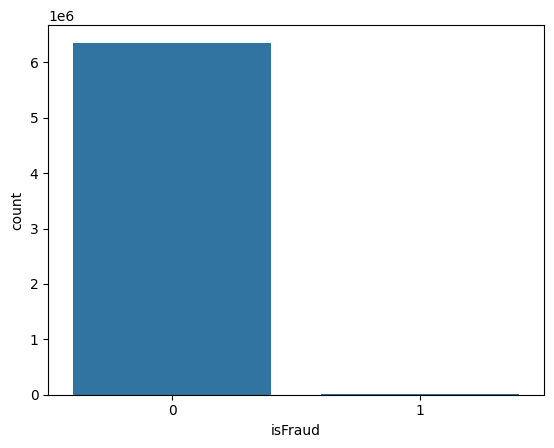

In [19]:
df['isFraud'].value_counts()
sns.countplot(x='isFraud', data=df)
plt.show()

## Data Cleaning

The dataset was examined for missing values, outliers, and multicollinearity.

- **Missing Values:**  
  No missing values were found in the dataset. This is expected since the data represents system-generated financial transactions.

- **Outliers:**  
  Transaction amounts and balance-related variables contain extreme values. In fraud detection, such extreme values often represent fraudulent behavior itself. Removing them could eliminate important fraud patterns, so outliers were retained.

- **Multicollinearity:**  
  Some balance variables show correlation (old and new balances). These were retained because balance differences provide meaningful signals for detecting fraudulent transactions.


In [20]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


## Feature Engineering

New features are created to capture transaction behavior:
- Difference in origin account balance
- Difference in destination account balance


In [21]:
df['origin_balance_diff'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['dest_balance_diff'] = df['newbalanceDest'] - df['oldbalanceDest']

Encoding Transaction Type

The `type` column is categorical and must be converted into numerical format.


In [22]:
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

## Feature Selection

High-cardinality identifiers such as transaction IDs do not add predictive value and are removed.


## Sampling Strategy

The original dataset contains over 6.3 million transactions, which is computationally expensive to process. To balance efficiency and model performance, a 15% stratified sample was used. This reduced the dataset size by approximately 85% (to around 950,000 transactions) while preserving the original fraud-to-non-fraud ratio. This approach ensures faster training without losing important fraud patterns.


In [23]:
df_model = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

In [24]:
df_sampled = df_model.groupby('isFraud', group_keys=False).apply(
    lambda x: x.sample(frac=0.15, random_state=42)
)
df_sampled['isFraud'].value_counts()

/tmp/ipython-input-435069657.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_model.groupby('isFraud', group_keys=False).apply(


,count
isFraud,
0,953161
1,1232


## Train-Test Split

The data is split into training and testing sets while maintaining the fraud ratio.


In [25]:
x=df_sampled.drop('isFraud', axis=1)
y=df_sampled['isFraud']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,stratify=y,random_state=42)

## Model Building

A Random Forest Classifier is used due to its robustness to outliers, ability to handle non-linear relationships, and effectiveness on imbalanced datasets.


In [26]:
rf = RandomForestClassifier(n_estimators=50,max_depth=15,min_samples_split=50,class_weight='balanced',random_state=42,n_jobs=-1)
rf.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_split=50, n_estimators=50, n_jobs=-1,
                       random_state=42)

## Model Evaluation

Evaluation is performed using metrics suitable for imbalanced classification:
- Confusion Matrix
- Precision, Recall, F1-score
- ROC-AUC Score


In [27]:
y_pred=rf.predict(x_test)
y_prob=rf.predict_proba(x_test)[:,1]
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    285948
           1       0.63      0.87      0.73       370

    accuracy                           1.00    286318
   macro avg       0.82      0.93      0.87    286318
weighted avg       1.00      1.00      1.00    286318



In [28]:
roc_auc_score(y_test,y_prob)

np.float64(0.99400484930354)

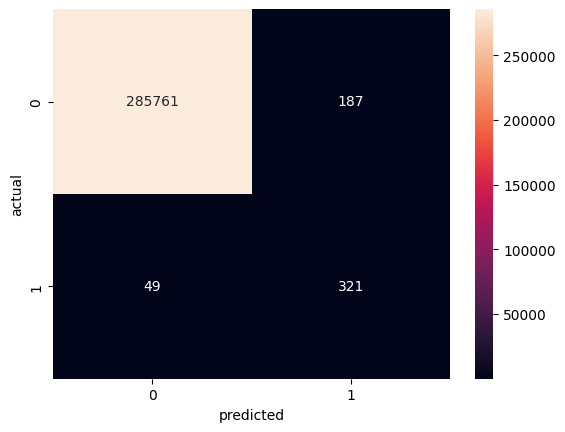

In [29]:
cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()

## Feature Importance

Feature importance helps identify key drivers of fraudulent behavior.


In [30]:
importances=pd.Series(rf.feature_importances_,index=x.columns)
importances.sort_values(ascending=False).head(10)

,0
origin_balance_diff,0.454099
oldbalanceOrg,0.148668
amount,0.120527
newbalanceOrig,0.092033
type,0.064800
dest_balance_diff,0.048816
step,0.037975
newbalanceDest,0.023111
oldbalanceDest,0.009970


## Key Factors Predicting Fraud

The most important factors identified by the model include:
- Transaction type (especially TRANSFER and CASH_OUT)
- Large transaction amounts
- Sudden reduction to zero balance in the origin account
- Destination accounts receiving funds without prior balance
- Large inconsistencies between old and new balances


## Do These Factors Make Sense?

Yes. Fraudsters typically:
- Perform large transfers
- Drain accounts completely
- Move funds to newly created or dormant accounts

These behaviors align with the model's top predictors.


## Fraud Prevention Strategy

Based on the model insights, the following prevention measures are recommended:
- Real-time transaction monitoring
- Multi-factor authentication for high-risk transactions
- Combining rule-based checks with machine learning models
- Behavioral profiling to detect unusual transaction patterns
- Periodic retraining of models to adapt to evolving fraud techniques


## Measuring Effectiveness of Prevention Measures

The effectiveness of the implemented fraud prevention strategies can be measured using metrics such as fraud detection rate, reduction in fraud-related losses, false positive rate, and customer complaints.

A/B testing, back-testing on historical data, and continuous monitoring can be used to ensure the system performs effectively over time.


## Conclusion

This project presents an end-to-end fraud detection solution using machine learning. The model successfully identifies fraudulent transactions and provides meaningful insights that can help financial institutions strengthen their fraud prevention infrastructure.
